# Total Perspective Vortex
- Date: `14-07-2023 3:30PM`
- Third project in the AI branch of 42's system
- Project description: 
    - `Learn to use python tools to process large dimension data, and create a man-machine interface thanks to brainwaves.`
- Summary: 
    - `Brain computer interface with machine learning based on electoencephalographic data.`
    - This subject aims to create a brain computer interface based on electroencephalographic
data (EEG data) with the help of machine learning algorithms. Using a subject’s EEG
reading, you’ll have to infer what he or she is thinking about or doing - (motion) A or B
in a t0 to tn timeframe.
- Goals:
    - Process EEG datas (parsing and filtering)
    - Implement a dimensionality reduction algorithm
    - Use the pipeline object from scikit-learn
    - Classify a data stream in "real time"

  ##### Update 28th December 2023 - Continuing the ongoing work.
    - Set up environment.
    - Load data.
    - Filter out bad frequencies.
    - Analyze.
 
  ---


![EEg-intro-cover](../assets/eeg-cover-intro.png)

---
## Steps:
V.1 Preprocessing, parsing and formating . <br>
V.2 Treatment pipeline . <br>
V.3 Implementation . <br>
V.4 Train, Validation and Test . <br>

---

#### we pick data related to hands vs feet
5, 9, 13 : Motor execution: hands vs feet (person executing the movement of his hands/feets for real)<br>
6, 10, 14 : Motor imagery: hands vs feet (person imagine the movement of his hands/feets)<br>
read: https://mne.tools/dev/generated/mne.datasets.eegbci.load_data.html

In [199]:

import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import mne
from mne import pick_types
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.preprocessing import ICA 

mne.set_log_level("CRITICAL")
# CRITICAL ?? ---> check descripton bellow

- **DEBUG:** Detailed information, typically useful for debugging.
- **INFO:** General information about the program's progress.
- **WARNING:** Indicates a potential issue that doesn't prevent the program from running.
- **ERROR:** Indicates a more serious issue that may prevent certain functionality.
- **CRITICAL:** Indicates a critical error that might lead to the program's termination.

Setting the logging level to "CRITICAL" is often done when you want to minimize the amount of console output, especially when running scripts or programs in production environments where detailed logging may not be necessary.

If you want more detailed logging information during development or debugging, you might use a higher logging level such as "DEBUG" or "INFO."

### Data loading:

- The code loads EEG data for executing and imagining motor tasks for specified subjects and runs.<br>
- For each subject and run combination, EEG data is loaded, and events corresponding to rest, foot movement, and hand movement are annotated.<br>
- Annotations are created for both executing and imagining motor tasks, and the annotations are set to the respective raw data.<br>
- The processed raw data is appended to the raw_files list.<br>
- This code is designed for loading and preprocessing EEG data for motor task execution and imagery, making it ready for further analysis.<br>

#### code details:
- **`mne.events_from_annotations`**: extracts events from annotations in the raw EEG data.<br>
It's applied separately to executing and imagining motor tasks.<br>
The event_id parameter maps annotation labels to event codes.
- **`mne.annotations_from_events`**: creates annotations from events.<br>
It maps events to descriptions using the provided mapping.<br>
Annotations include information about event timing and descriptions.
    - ##### Parameters:
        - `events`: Event array.
        - `event_desc`: Dictionary mapping event codes to descriptions.
        - `sfreq`: Sampling Frequency:<br>
            - In the context of EEG data, the sfreq parameter stands for the "sampling frequency" of the raw data.<br>
            - Sampling frequency represents the number of samples (data points) obtained per unit of time, usually expressed in Hertz (Hz).<br>
            - For EEG data, the sampling frequency indicates how many samples are collected per second. Higher sampling frequencies provide more temporal detail but may require more storage and processing resources.<br>
            - In this code, raw_execution.info['sfreq'] retrieves the sampling frequency from the information associated with the raw_execution object.
        - `orig_time`: Original measurement time of the raw data.<br>
            - The orig_time parameter represents the original measurement time of the raw EEG data.<br>
            - It indicates the specific time point when the EEG recording began.<br>
            - The information about the original measurement time is important for maintaining the temporal context of the EEG data.<br>
            - In this code, raw_execution.info['meas_date'] retrieves the original measurement time from the information associated with the raw_execution object.<br>


In [52]:
# EEG Data Loading and Annotation

# - T0 corresponds to rest
# - T1 corresponds to the onset of motion (real or imagined) of the left fist (in runs 3, 4, 7, 8, 11, and 12)
#   or both fists (in runs 5, 6, 9, 10, 13, and 14)
# - T2 corresponds to the onset of motion (real or imagined) of the right fist (in runs 3, 4, 7, 8, 11, and 12)
#   or both feet (in runs 5, 6, 9, 10, 13, and 14)

subject = [1]  # List of subject numbers (e.g., [1, 4])
run_execution = [5, 9, 13]  # Runs for executing motor tasks
run_imagery = [6, 10, 14]  # Runs for imagining motor tasks

raw_files = []

# Loop through each subject and associated runs for execution and imagery
for person_number in subject:
    for i, j in zip(run_execution, run_imagery):
        # Load EEG data for executing motor tasks
        raw_files_execution = [read_raw_edf(f, preload=True, stim_channel='auto') for f in eegbci.load_data(person_number, i)]
        raw_execution = concatenate_raws(raw_files_execution)

        # Load EEG data for imagining motor tasks
        raw_files_imagery = [read_raw_edf(f, preload=True, stim_channel='auto') for f in eegbci.load_data(person_number, j)]
        raw_imagery = concatenate_raws(raw_files_imagery)

        # Extract events and create annotations for executing motor tasks
        events, _ = mne.events_from_annotations(raw_execution, event_id=dict(T0=1, T1=2, T2=3))
        mapping = {1: 'rest', 2: 'do/feet', 3: 'do/hands'}
        annot_from_events = mne.annotations_from_events(
            events=events, event_desc=mapping, sfreq=raw_execution.info['sfreq'],
            orig_time=raw_execution.info['meas_date'])
        raw_execution.set_annotations(annot_from_events)

        # Extract events and create annotations for imagining motor tasks
        events, _ = mne.events_from_annotations(raw_imagery, event_id=dict(T0=1, T1=2, T2=3))
        mapping = {1: 'rest', 2: 'imagine/feet', 3: 'imagine/hands'}
        annot_from_events = mne.annotations_from_events(
            events=events, event_desc=mapping, sfreq=raw_imagery.info['sfreq'],
            orig_time=raw_imagery.info['meas_date'])
        raw_imagery.set_annotations(annot_from_events)

        # Append the processed raw data to the list
        raw_files.append(raw_execution)
        raw_files.append(raw_imagery)


In [53]:
raw = concatenate_raws(raw_files)
originalRaw = raw.copy()
events, event_dict = mne.events_from_annotations(raw)
data = raw.get_data()

# display(raw.info)
print(len(events), event_dict)
# display(raw.ch_names)
# display(data)
fig = raw.plot()



180 {'do/feet': 1, 'do/hands': 2, 'imagine/feet': 3, 'imagine/hands': 4, 'rest': 5}


In [54]:
raw.filter(1, 20)

Measurement date,"August 12, 2009 16:15:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,64 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,160.00 Hz
Highpass,1.00 Hz
Lowpass,20.00 Hz


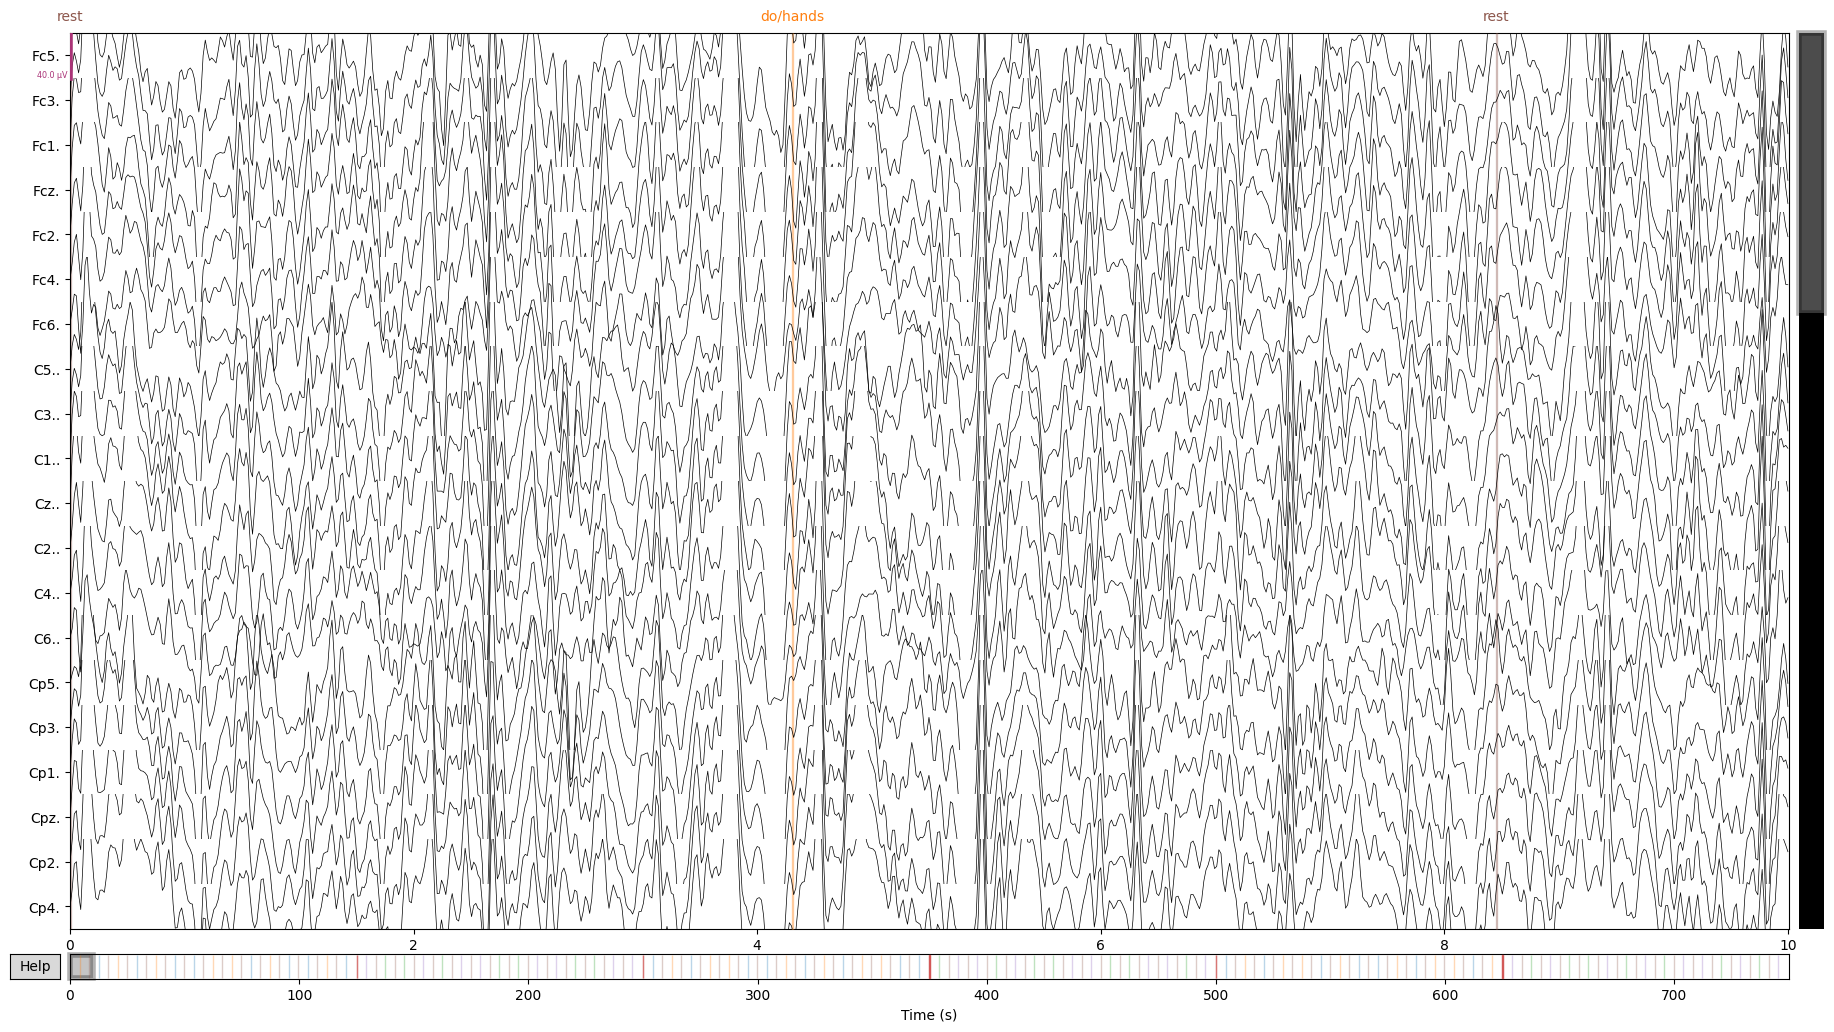

''

In [66]:
raw.plot()
;

### filter any bad channels that were identified to have artifacts

In [67]:
# filter any bad channels that were identified to have artifacts
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
print(picks)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


## Standard montages
**Standard Montage**: A standard montage defines the standardized positions of electrodes on the scalp. <br>
Different standard montages provided by MNE-Python:
- **'standard_1020'**: This is a standard EEG electrode montage with 21 electrodes based on the international 10-20 system.
- **'standard_1005'**: Another standard EEG electrode montage with 348 electrodes based on the extended 10-05 system.
- **'biosemi32'**: A BioSemi montage with 32 electrodes.

**BioSemi** *is a company that specializes in the development and manufacturing of EEG (electroencephalogram) and other neurophysiological equipment. The BioSemi EEG system is a type of EEG recording system produced by BioSemi.*

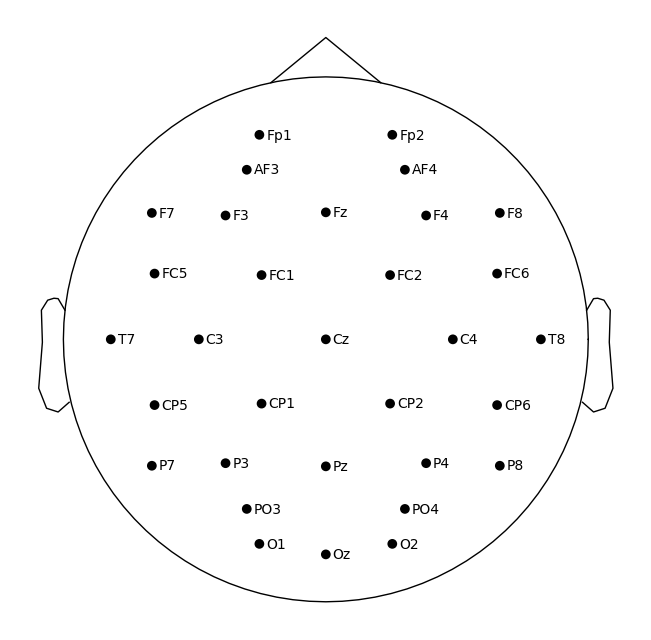

''

In [70]:
biosemi_montage = make_standard_montage('biosemi32')
fig = biosemi_montage.plot()
;

Sets the EEG channel names and applies a standard EEG montage, which includes digitization points for the EEG electrodes.

This is a common and necessary step when working with EEG data in MNE-Python.

- **`eegbci.standardize(raw)`**: This function is used to standardize the channel names of the EEG data. It ensures that the channel names follow a consistent naming convention, making it easier to work with standard montages.

- **`make_standard_montage('standard_1005')`**: This function creates a standard EEG electrode montage based on the 10/05 system, which is a widely used electrode placement system. It defines the positions of EEG electrodes on the scalp.

- **`raw.set_montage(montage)`**: This line sets the created electrode montage (montage) to the EEG data in the raw object. This step aligns the electrode positions in the data with the standard positions defined by 'standard_1005', facilitating accurate spatial analysis.

In [71]:
eegbci.standardize(raw)  # set channel names
# the update is saved inside 'raw' buffer

montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

Measurement date,"August 12, 2009 16:15:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,67 points
Good channels,64 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,160.00 Hz
Highpass,1.00 Hz
Lowpass,20.00 Hz


---
## Power Spectral Density (PSD)
Plot the power spectral density (PSD) of the EEG data stored in the raw object. Here's what each line does:
Power Spectral Density (PSD) just descrives the characteristics of time signals (RMS on Frequency range))
- `raw.plot_psd(average=False)`: 
    - This line generates a plot of the power spectral density of the EEG data. 
    - The `average=False` argument means that it will plot the PSD separately for each channel rather than averaging across channels.

#### ressources:
- What is a power spectrum?: https://youtu.be/Gka11q5VfFI

/home/allali/Desktop/school/42-total-perspective-vortex/tenv/lib/python3.10/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/home/allali/Desktop/school/42-total-perspective-vortex/tenv/lib/python3.10/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


''

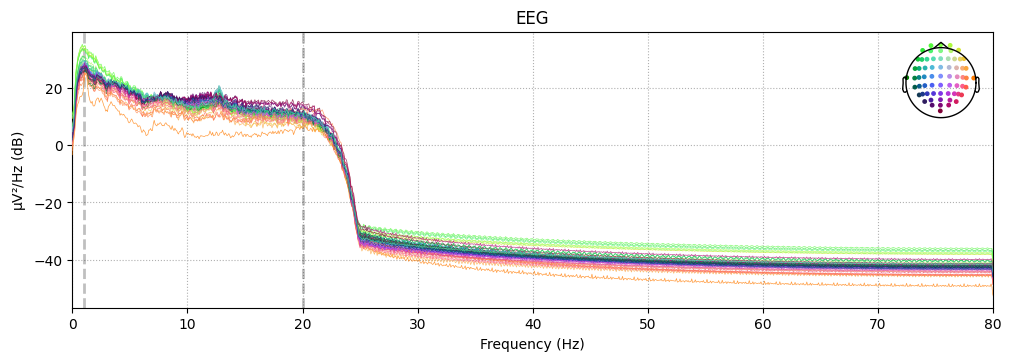

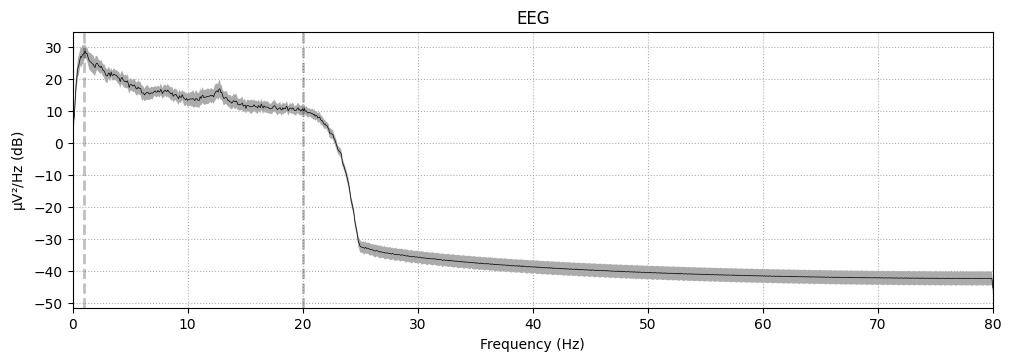

In [73]:
raw.plot_psd(average=False)
raw.plot_psd(average=True)
;

#### In a power spectral density (PSD) plot for EEG data, the two dotted vertical lines pointing to a range between 5 and 20 Hz typically indicate the frequency range of interest, often referred to as a specific frequency band.

The frequency range of interest in the context of EEG analysis typically includes the theta band (4-7 Hz), alpha band (8-13 Hz), beta band (13-30 Hz), and gamma band (30 Hz and above), with specific focus depending on the cognitive states or tasks under investigation.

- **Theta Band (4-7 Hz)**: The lower dotted line around 5 Hz might represent the lower bound of the theta frequency band, associated with drowsiness, relaxation, and light sleep.

- **Alpha Band (8-13 Hz)**: The upper dotted line around 20 Hz might represent the upper bound of the alpha frequency band, associated with a ***relaxed but awake state***. Alpha activity is often prominent when the ***eyes are closed***.

- **Beta Band (13-30 Hz)**: The beta frequency band in EEG typically falls in the range of approximately 13 to 30 Hz. In a power spectral density (PSD) plot, you would expect the beta band to be situated between the alpha and gamma bands. It's often associated with active cognitive ***processing, concentration, and alertness***.

- **Gamma Band (30-... Hz)** The gamma frequency range of approximately 30 Hz and above. Gamma oscillations are associated with ***high-frequency neural activity*** and are often linked to processes involving cognitive functions such as ***perception, attention, and memory encoding***.

These frequency bands are commonly examined in EEG analysis to study different cognitive states and physiological phenomena. 

The vertical lines serve as a visual guide to highlight specific frequency ranges of interest on the PSD plot. 

Researchers often focus on these bands to analyze brain activity related to different mental states or tasks.

---

## Events


1. `fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp, event_id=event_dict)`: This line generates an event plot using MNE-Python's `plot_events` function. It visualizes the occurrence and types of events in the EEG data.

   - `events`: This is a NumPy array containing event information, typically obtained from an event file associated with the EEG recording.
   - `sfreq=raw.info['sfreq']`: Specifies the sampling frequency of the EEG data, which is extracted from the information stored in the `raw` object.
   - `first_samp=raw.first_samp`: Specifies the index of the first sample in the raw data. It ensures correct alignment of events with the EEG data.
   - `event_id=event_dict`: Specifies a dictionary mapping event labels to event codes. This helps in labeling different types of events in the plot.

2. `fig.subplots_adjust(right=0.7)`: This line adjusts the layout of the subplots in the figure, specifically expanding the space on the right side of the plot. It's often used to make room for legend annotations or additional information.

In summary, these lines create an event plot for EEG data, displaying the timing and types of events, and adjust the layout of the plot to accommodate additional information on the right side.

In [74]:
print(":- random chunk of events = ", events[10:20])
print(":- raw.info['sfreq'] = ", raw.info['sfreq'])
print(":- first_samp = ", raw.first_samp)
print(":- event_id = ", event_dict)


:- random chunk of events =  [[ 6640     0     5]
 [ 7312     0     1]
 [ 7968     0     5]
 [ 8640     0     1]
 [ 9296     0     5]
 [ 9968     0     2]
 [10624     0     5]
 [11296     0     2]
 [11952     0     5]
 [12624     0     1]]
:- raw.info['sfreq'] =  160.0
:- first_samp =  0
:- event_id =  {'do/feet': 1, 'do/hands': 2, 'imagine/feet': 3, 'imagine/hands': 4, 'rest': 5}


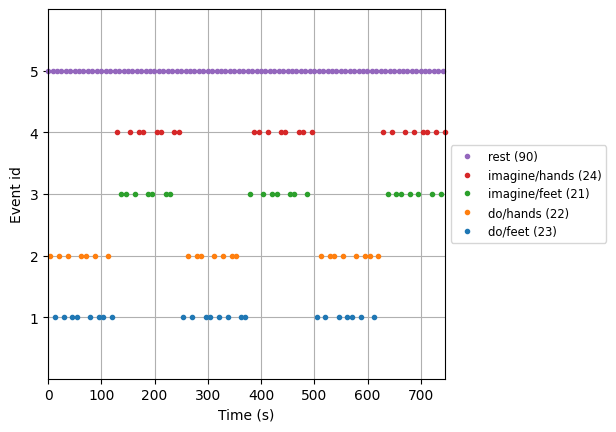

In [75]:
fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp, event_id=event_dict)
# fig.subplots_adjust(right=0.7)


---

## Band-Pass filter to EEG data:

- `raw.filter(5., 40., fir_design='firwin', skip_by_annotation='edge')`:

  - `raw`: This refers to the raw EEG data stored in the `raw` object.

  - `filter(5., 40., ...)`: This function filters the EEG data. The parameters `5.` and `40.` specify the frequency range for the band-pass filter, allowing frequencies between 5 Hz and 40 Hz to pass through.

  - `fir_design='firwin'`: Specifies the use of the Finite Impulse Response (FIR) filter design method called 'firwin'. FIR filters are commonly used in signal processing, and 'firwin' is a specific design method within MNE-Python.

  - `skip_by_annotation='edge'`: This parameter skips data marked by annotations, particularly useful for avoiding filter artifacts at the edges of data segments. Annotations are labels associated with specific time intervals in the EEG data.

The choice of the FIR (Finite Impulse Response) filter design method, in this case, 'firwin', determines how the coefficients of the filter are calculated. 'firwin' refers to the FIR window design method in MNE-Python.

The FIR filter design typically involves selecting a window function (such as Hamming, Hann, or Blackman) and applying it to the ideal filter response in the frequency domain. The resulting filter coefficients are then determined by the inverse Fourier transform of the windowed frequency response.

AKA: `filters the raw EEG data using a band-pass filter with a frequency range of 5 Hz to 40 Hz, employing the 'firwin' design method, and skips data marked with annotations at the edges to avoid artifacts.`

/home/allali/Desktop/school/42-total-perspective-vortex/tenv/lib/python3.10/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


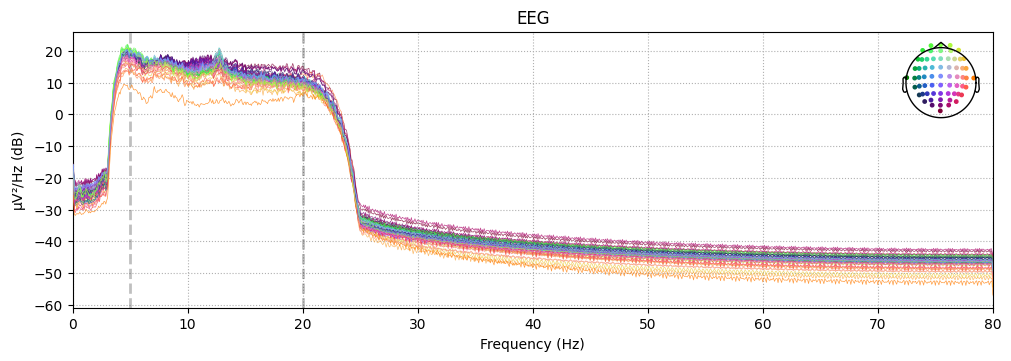

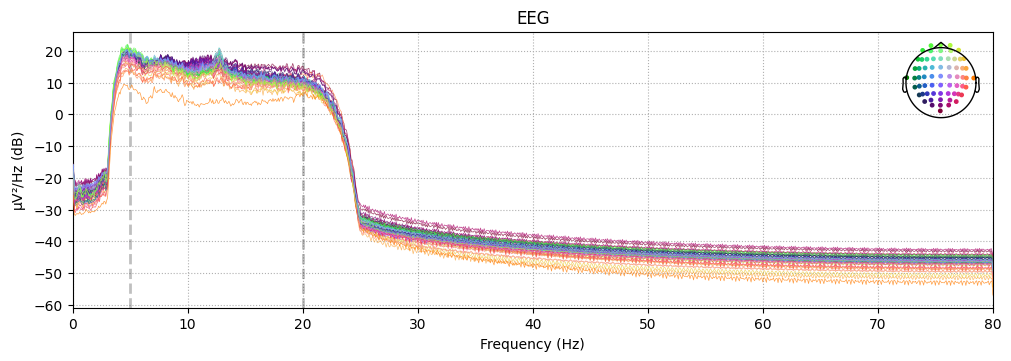

In [76]:
raw.filter(5., 40., fir_design='firwin', skip_by_annotation='edge')
raw.plot_psd(average=False)


##  Independent Component Analysis (ICA) 
إستأصال الترددات المتداخلة مع الدماغ عن طريق التعلم العميق للالة المعد مسبفا 

##### perform Independent Component Analysis (ICA) on EEG data to identify and visualize independent components. 
##### It specifically focuses on identifying components related to eye movements (EOG artifacts) and prints the indices of the identified "bad" components. 
##### These components can then be excluded from further analysis or removed from the data to enhance the quality of EEG recordings.
- `rawClone = raw.copy()`: This line creates a copy of the raw EEG data. The raw object is typically an instance of the mne.io.Raw class representing continuous EEG data. Creating a copy (rawClone) is a common practice to avoid modifying the original data during processing.
- `ica = ICA(n_components=20, method='fastica', random_state=97)`: This line initializes an Independent Component Analysis (ICA) object. ICA is a technique used for blind source separation and is commonly applied to EEG data to identify and remove artifacts. The parameters specified include:
    - `n_components=20`: Specifies the number of independent components to estimate. In this case, it's set to 20.
      - explanation:
        - indicates that you are requesting the ICA algorithm to identify and separate the EEG data into 20 independent components. Each independent component represents a linear combination of the original EEG channels, capturing different sources of neural or non-neural activity.
        - Choosing the appropriate number of components is a crucial step in ICA. If the number is too low, you may not capture all relevant sources in the data. If it's too high, you might end up with components that represent noise or overfit the data.
        - In practice, determining the optimal number of components often involves exploring the data and using domain knowledge or statistical criteria to guide the selection. Researchers might assess the explained variance, examine the topographic maps of the components, or use other metrics to guide the choice of n_components based on the characteristics of the EEG data and the goals of the analysis.

    - `method='fastica'`: Specifies the ICA algorithm to use. 'fastica' is a commonly used algorithm for EEG artifact removal.
    - `random_state=97`: Sets the random seed for reproducibility. The same seed ensures that the results are consistent across runs.
- `ica.fit(rawClone, picks=picks)`: This line fits the ICA model to the EEG data (rawClone). The picks parameter is used to specify the subset of channels on which to perform the ICA. It's a good practice to limit the ICA to relevant channels, often excluding certain channels like EOG (electrooculogram) or other non-EEG channels.

- `ica.plot_components()`: This line generates a plot of the independent components estimated by the ICA. The purpose of this plot is to visually inspect the components and identify those that correspond to artifacts (such as eye blinks, muscle activity) as opposed to neural sources.

- `eog_indicies, scores= ica.find_bads_eog(raw, ch_name='Fpz', threshold=1.5)`: This line identifies "bad" independent components that likely represent artifacts related to eye movements. It uses the find_bads_eog method, which leverages information about the EOG channels ('Fpz' in this case) to identify components associated with eye movements. The threshold parameter determines the sensitivity of the algorithm.

- `print("Bad indicies: " + str(eog_indicies))`: This line prints the indices of the identified "bad" independent components. These components can be further inspected and potentially removed from the EEG data to improve data quality.

Applying ICA ... (please wait)
plotting...


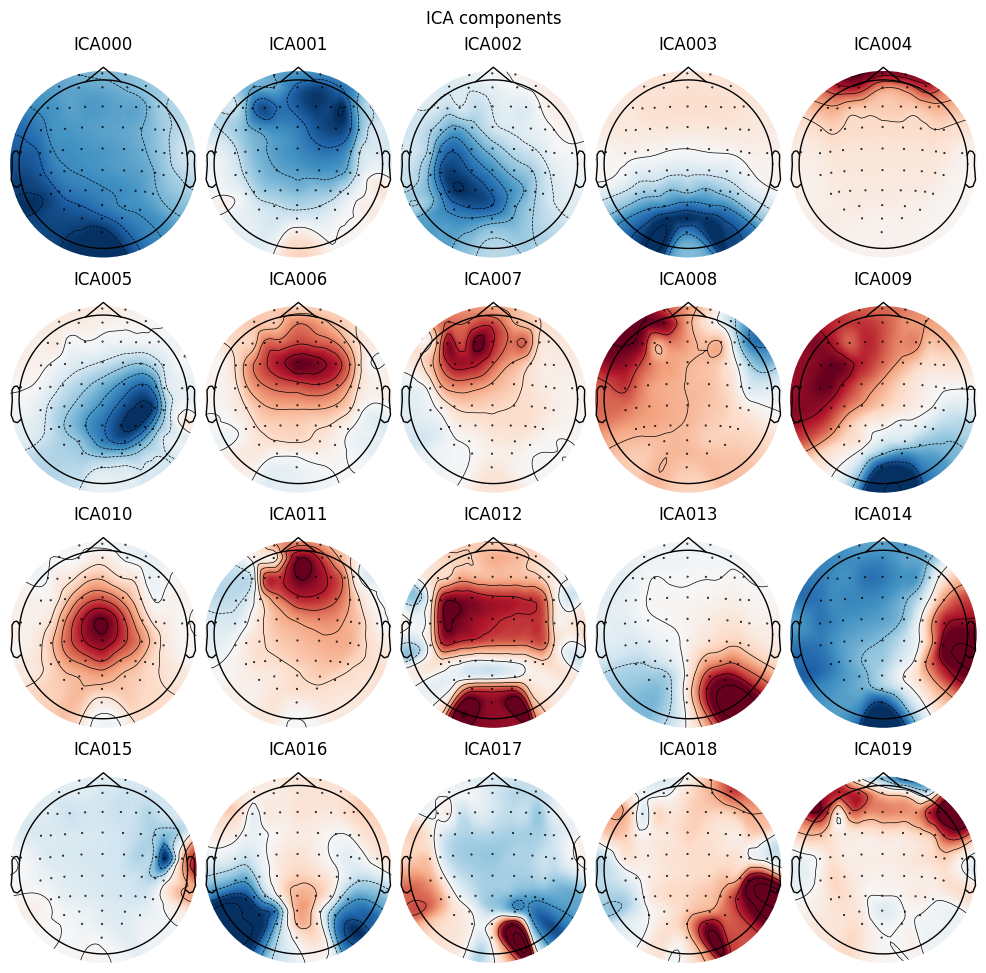

''

In [77]:
rawCopy = raw.copy()
number_components = 20

print("Applying ICA ... (please wait)")

ica = ICA(n_components=number_components, method='fastica', random_state=0)
ica.fit(rawCopy, picks=picks)

print("plotting...")
ica.plot_components()
;
    

## Identify components related to eye movement artifacts.
in this code snippet below, we will exclude bad EOG from our data.

EOG = **Electrooculogram**
- **Source:** Electrical signals generated by eye movements.
- **Recorded with:** Electrodes placed around the eyes (e.g., above/below or at the outer canthi).
- **Artifacts:** Introduces artifacts in EEG due to blinks and saccades.
- **Blinks:** Closing and opening of eyes during blinks cause transient electrical signals.
- **Saccades:** Rapid eye movements introduce shifts in the recorded electrical field.
- **Artifact Removal:** Essential for accurate EEG analysis; techniques like Independent Component Analysis (ICA) are used.
- **Minimization:** Researchers instruct participants to minimize eye movements during EEG recording.
- **Relevance:** Capturing and managing EOG activity is crucial for clean EEG data analysis.

The `ch_name='Fpz'` parameter specifies the channel name to be used for identifying components related to eye movements (EOG artifacts). The 'Fpz' designation typically refers to the frontal polar electrode, which is often used in EEG recordings.

Here's why specifying the channel name is important:

1. **Localization of EOG Activity:** EOG artifacts are commonly associated with eye movements, and the activity is often prominent around the eyes. By specifying the channel name ('Fpz'), you are indicating that the algorithm should focus on EOG activity recorded at or near the frontal polar electrode.

2. **Choice of EOG Channel:** Different EEG setups may have electrodes placed at various locations, and the choice of the channel for EOG detection depends on the electrode configuration used in the recording. 'Fpz' is a common choice, but depending on the setup, other channels near the eyes may also be used.

3. **Consistency Across Data:** If you know that EOG activity is likely to be captured well by a specific electrode (e.g., 'Fpz') across multiple recordings or subjects, specifying the channel name helps maintain consistency in the preprocessing pipeline.

In summary, `ch_name='Fpz'` is used to guide the EOG artifact detection algorithm to focus on the EEG channel that is expected to capture relevant EOG activity, helping to improve the accuracy of identifying and removing EOG-related components during the Independent Component Analysis (ICA) process.

### What is Threshold ?

Let's consider a hypothetical list of scores associated with independent components, and we'll apply a threshold of 1.5 times the standard deviation to identify potential EOG-related components. Here's a simple example:


**Standard Deviation is a statistical measure of the amount of variation or dispersion in a set of values. It quantifies how much individual values deviate from the mean of the dataset, providing insight into the overall spread of the data.**

Assume the following scores for independent components:

\[ [2, 1, 3, 4, 6, 8, 5, 7, 10, 12] \]

Now, let's calculate the threshold:

**Threshold = 1.5 * Standard Deviation of Scores**

1. Calculate the Mean:
   - `mean = sum(scores) / len(scores)`

3. Calculate the Squared Differences from the Mean:
   - `squared_diff = [(x - mean) ** 2 for x in scores]`

5. Calculate the Variance:
   - `variance = sum(squared_diff) / len(scores)`

7. Calculate the Standard Deviation:
   - `std_deviation = sqrt(variance)`

9. Set the Threshold Multiplier:
   - `threshold_multiplier = 1.5`

11. Calculate the Threshold:
    - `threshold = threshold_multiplier * std_deviation`

Now, we compare each score to the threshold:

`[2, 1, 3, 4, 6, 8, 5, 7, 10, 12]`

Assuming a mean (ˉx)) of 6 for simplicity (not an actual calculation but for illustration):
- Standard Deviation ≈ 3.42
- Threshold = 1.5 × 3.42 ≈ 5.13
- Scores below the threshold (2, 1, 3, 4) may be considered potential EOG-related components.
- Scores above the threshold (6, 8, 5, 7, 10, 12) may be considered less likely to be EOG-related.

In this simplified example, components with scores below the threshold might be flagged for potential exclusion as they deviate significantly from the mean. Keep in mind that the actual calculations would involve the real mean and standard deviation of the scores in your data. Adjusting the threshold value would influence the sensitivity of the EOG detection process.


--------------------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------- [ Plot Scores/Indices ] --------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------------------------------

Bad indices:  [4, 0, 1]


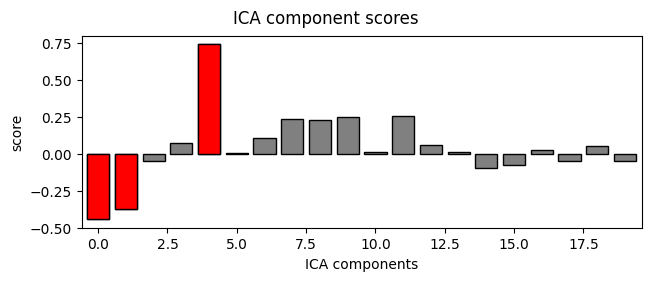

In [78]:
eog_indicies, scores = ica.find_bads_eog(raw, ch_name='Fpz', threshold=1.5)
print(("--" * 70 + "\n"))
print(("--" * 29 + " [ Plot Scores/Indices ] " + "--" * 28 + "\n"))
print(("--" * 70 + "\n"))
print("Bad indices: ", eog_indicies)
ica.plot_scores(scores, exclude=eog_indicies)
ica.exclude.extend(eog_indicies)
rawCopy = ica.apply(rawCopy, n_pca_components = number_components, exclude = ica.exclude)


Number of channels: 64
Total duration: 749.99375 seconds


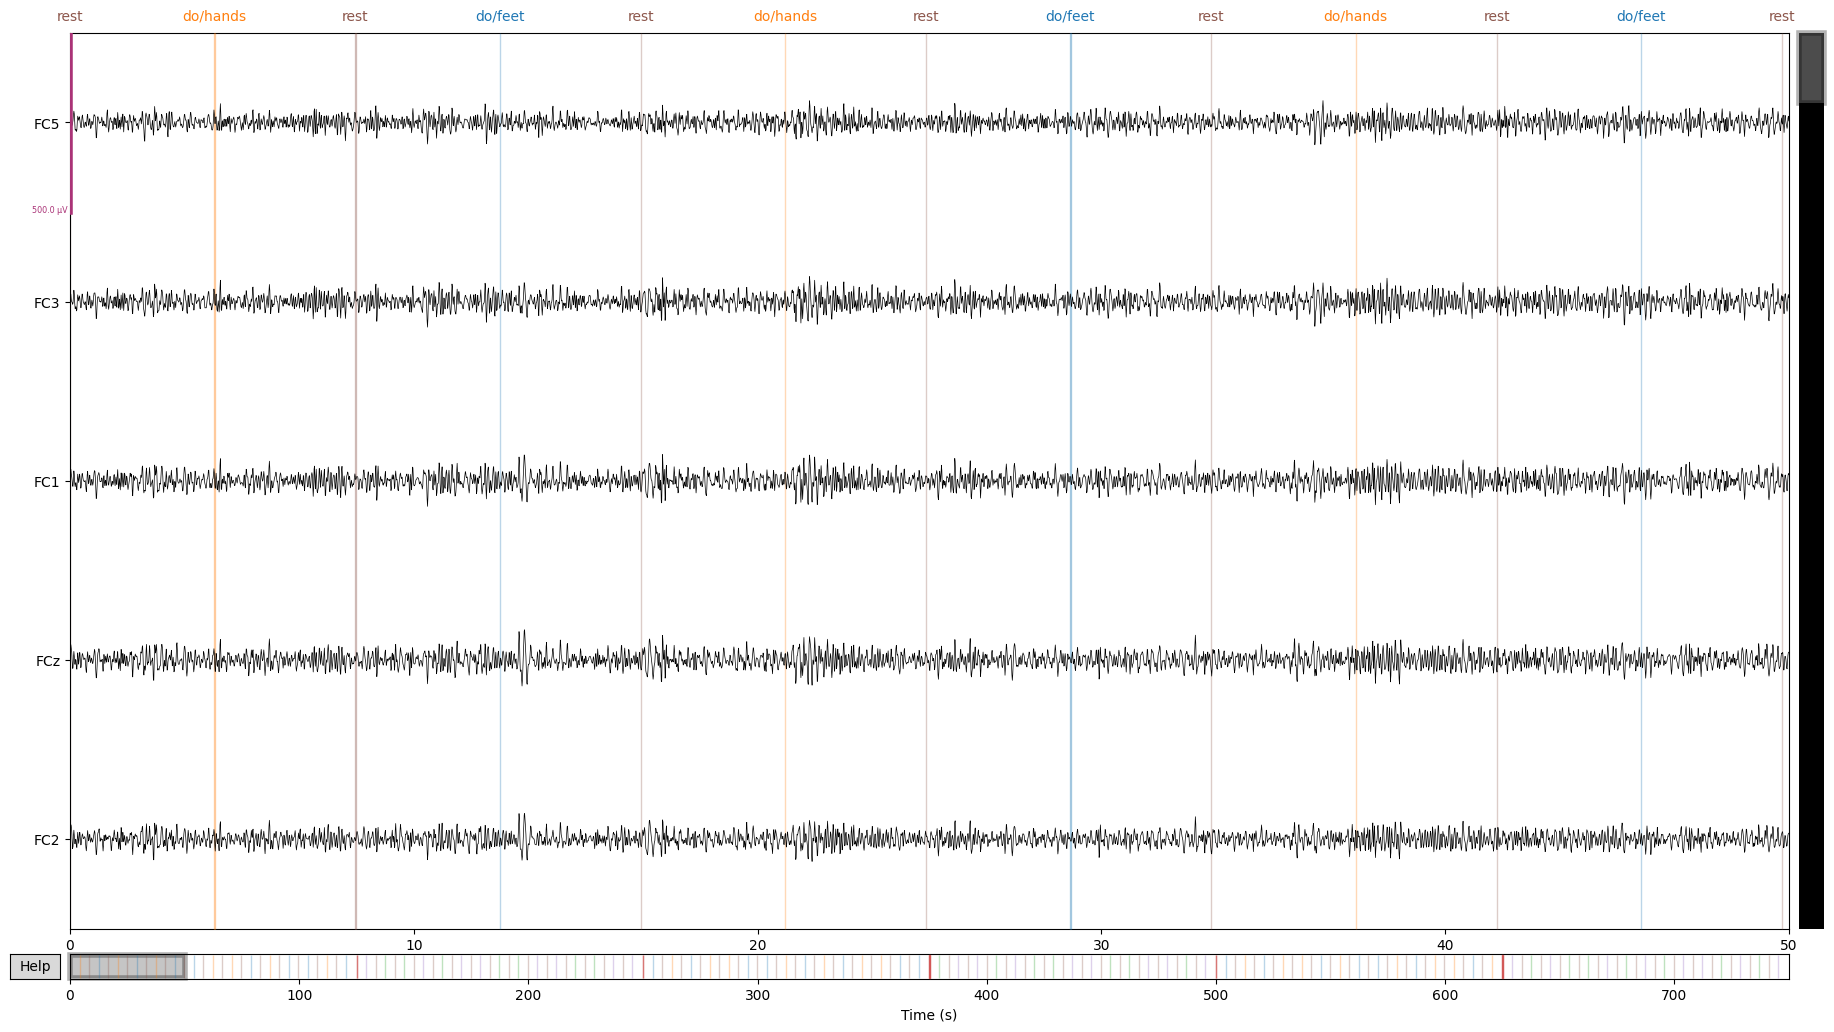

In [79]:
print("Number of channels:", len(raw.ch_names))
print("Total duration:", raw.times[-1], "seconds")
rawCopy.plot(n_channels=5, start=0, duration=50, scalings=dict(eeg=250e-6))
# rawCopy.plot(n_channels=64, start=0, duration=50, scalings=dict(eeg=250e-6))

plt.show()

## Before and After:
### demo with 3 channels only, for clear plotting

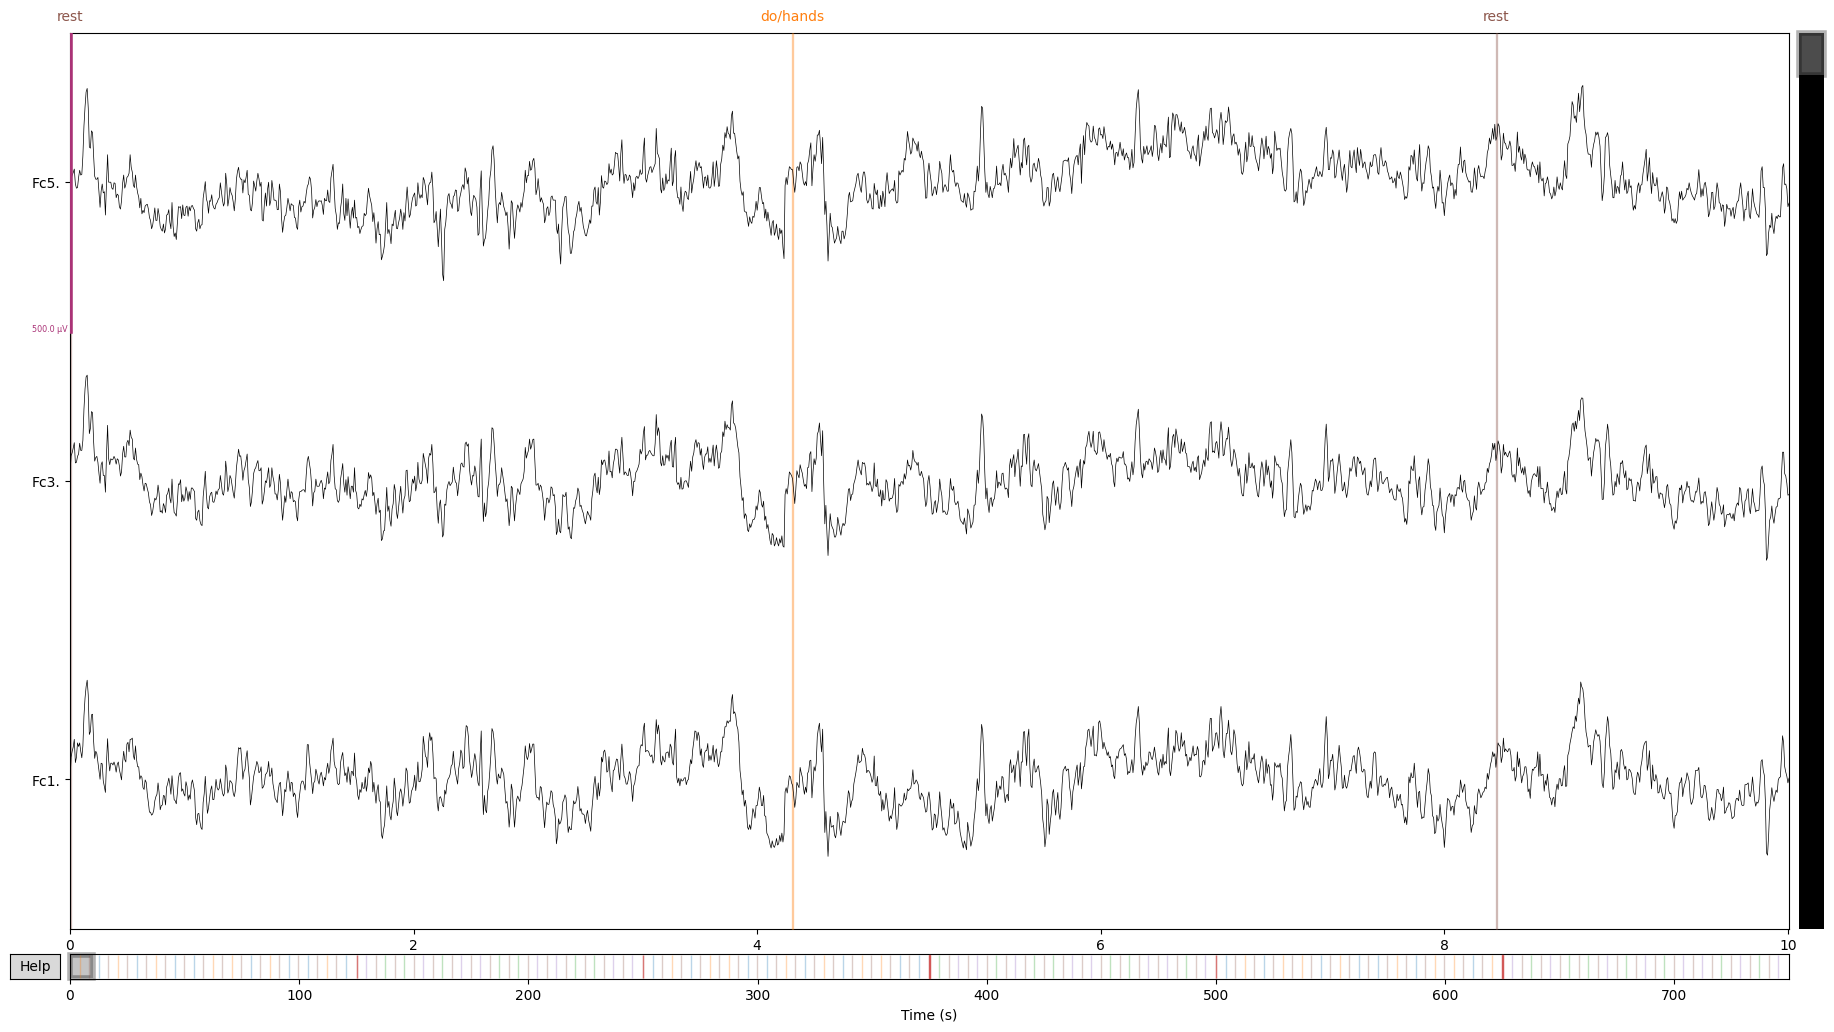

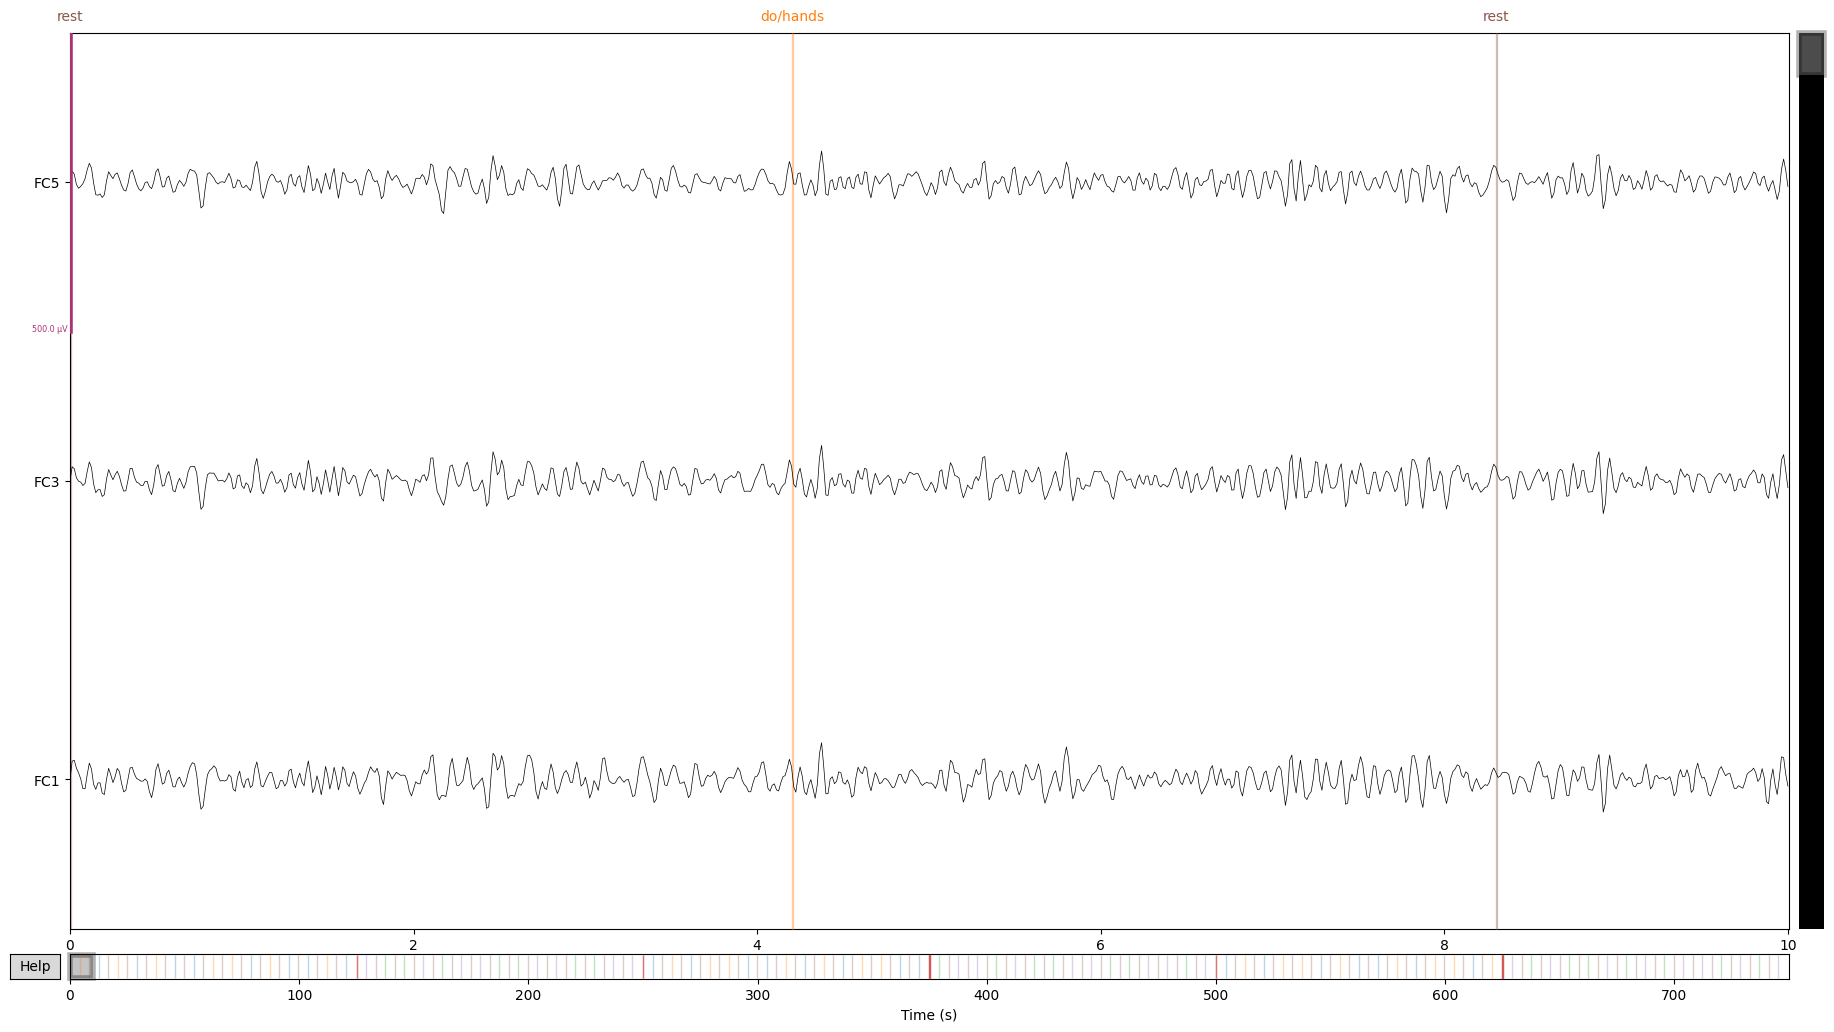

In [80]:
originalRaw.plot(n_channels=3, scalings=dict(eeg=250e-6))
rawCopy.plot(n_channels=3, scalings=dict(eeg=250e-6))
plt.show()

## Share Data with other notebooks

In [198]:
!pip install pickleshare
# Notebook 1
from pickleshare import PickleShareDB
db = PickleShareDB('./tmp')
db['raw'] = rawCopy
db['originalRaw'] = originalRaw
